<a href="https://colab.research.google.com/github/VidushiBhatia/Customer-Segmentation/blob/main/Customer_Segmentation_Case_Study_Instacart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end segmentation implementation on [Instacart](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)

## 1. Install Relevant Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
from matplotlib.pyplot import plot
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
!pip install kneed
from kneed import KneeLocator
from sklearn.metrics import silhouette_score


## 2. Read Files and Understand Data

   * Read all the files
   * Review Tables to get a sense of the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
############################################ Helper Function 1 ############################################################
############################################### READ FILES ################################################################

def read_data(path):
  all_dfs = {}
  df = pd.DataFrame()
  files = os.listdir(path) 
  missing_value_formats = ["n.a.","?","NA","n/a", "na", "--","-"]
  
  for file in files:
    if file.endswith('.csv'):
      all_dfs[file[:file.find(".")]] = pd.read_csv(os.path.join(path,file), na_values = missing_value_formats)
  return all_dfs

############################################ Helper Function 2 ############################################################
############################################ SUMMARIZE FILES ##############################################################

def summarize_data(df):
  print("\nOverview")
  display(df.head())
  print("\nSummary")
  display(df.describe(include='all'))
  print("\nNull Values")
  display(df.isnull().sum()/len(df))

In [5]:
# Understand the available data

path = '/content/drive/MyDrive/instacart-market-basket-analysis/'
all_dfs = read_data(path)

print("\n############################## AISLES ##############################")
summarize_data(all_dfs['aisles'])
print("\n############################## DEPARTMENTS ##############################")
summarize_data(all_dfs['departments'])
print("\n############################## ORDER-PRODUCTS PRIOR ##############################")
summarize_data(all_dfs['order_products__prior'])
print("\n############################## ORDER-PRODUCTS TRAIN ##############################")
summarize_data(all_dfs['order_products__train'])
print("\n############################## ORDERS ##############################")
summarize_data(all_dfs['orders'])
print("\n############################## PRODUCTS ##############################")
summarize_data(all_dfs['products'])
print("\n############################## SAMPLE SUBMISSION ##############################")
summarize_data(all_dfs['sample_submission'])



############################## AISLES ##############################

Overview


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation



Summary


,aisle_id,aisle
count,134.000000,134
unique,NaN,134
top,NaN,instant foods
freq,NaN,1
mean,67.500000,NaN
std,38.826537,NaN
min,1.000000,NaN
25%,34.250000,NaN
50%,67.500000,NaN
75%,100.750000,NaN



Null Values


aisle_id    0.0
aisle       0.0
dtype: float64


############################## DEPARTMENTS ##############################

Overview


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol



Summary


,department_id,department
count,21.000000,21
unique,NaN,21
top,NaN,frozen
freq,NaN,1
mean,11.000000,NaN
std,6.204837,NaN
min,1.000000,NaN
25%,6.000000,NaN
50%,11.000000,NaN
75%,16.000000,NaN



Null Values


department_id    0.0
department       0.0
dtype: float64


############################## ORDER-PRODUCTS PRIOR ##############################

Overview


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0



Summary


,order_id,product_id,add_to_cart_order,reordered
count,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07
mean,1.710749e+06,2.557634e+04,8.351076e+00,5.896975e-01
std,9.873007e+05,1.409669e+04,7.126671e+00,4.918886e-01
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.559430e+05,1.353000e+04,3.000000e+00,0.000000e+00
50%,1.711048e+06,2.525600e+04,6.000000e+00,1.000000e+00
75%,2.565514e+06,3.793500e+04,1.100000e+01,1.000000e+00
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00



Null Values


order_id             0.0
product_id           0.0
add_to_cart_order    0.0
reordered            0.0
dtype: float64


############################## ORDER-PRODUCTS TRAIN ##############################

Overview


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1



Summary


,order_id,product_id,add_to_cart_order,reordered
count,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06
mean,1.706298e+06,2.555624e+04,8.758044e+00,5.985944e-01
std,9.897326e+05,1.412127e+04,7.423936e+00,4.901829e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.433700e+05,1.338000e+04,3.000000e+00,0.000000e+00
50%,1.701880e+06,2.529800e+04,7.000000e+00,1.000000e+00
75%,2.568023e+06,3.794000e+04,1.200000e+01,1.000000e+00
max,3.421070e+06,4.968800e+04,8.000000e+01,1.000000e+00



Null Values


order_id             0.0
product_id           0.0
add_to_cart_order    0.0
reordered            0.0
dtype: float64


############################## ORDERS ##############################

Overview


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0



Summary


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3421083,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
unique,NaN,NaN,3,NaN,NaN,NaN,NaN
top,NaN,NaN,prior,NaN,NaN,NaN,NaN
freq,NaN,NaN,3214874,NaN,NaN,NaN,NaN
mean,1.710542e+06,1.029782e+05,NaN,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,NaN,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,NaN,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,NaN,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,NaN,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,NaN,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01



Null Values


order_id                  0.000000
user_id                   0.000000
eval_set                  0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    0.060276
dtype: float64


############################## PRODUCTS ##############################

Overview


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13



Summary


,product_id,product_name,aisle_id,department_id
count,49688.000000,49688,49688.000000,49688.000000
unique,NaN,49688,NaN,NaN
top,NaN,Walnuts Halves & Pieces Organic,NaN,NaN
freq,NaN,1,NaN,NaN
mean,24844.500000,NaN,67.769582,11.728687
std,14343.834425,NaN,38.316162,5.850410
min,1.000000,NaN,1.000000,1.000000
25%,12422.750000,NaN,35.000000,7.000000
50%,24844.500000,NaN,69.000000,13.000000
75%,37266.250000,NaN,100.000000,17.000000



Null Values


product_id       0.0
product_name     0.0
aisle_id         0.0
department_id    0.0
dtype: float64


############################## SAMPLE SUBMISSION ##############################

Overview


,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259



Summary


,order_id,products
count,7.500000e+04,75000
unique,NaN,1
top,NaN,39276 29259
freq,NaN,75000
mean,1.709686e+06,NaN
std,9.878542e+05,NaN
min,1.700000e+01,NaN
25%,8.557232e+05,NaN
50%,1.710152e+06,NaN
75%,2.562794e+06,NaN



Null Values


order_id    0.0
products    0.0
dtype: float64

In [6]:
# MISSING VALUE TREATMENT

# Checking reason for Missing values and applying apt missing value treatment

all_dfs['orders'].loc[all_dfs['orders']['order_number']==1, 'days_since_prior_order'] = 0
summarize_data(all_dfs['orders'])


Overview


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,0.0
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0



Summary


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3421083,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06
unique,NaN,NaN,3,NaN,NaN,NaN,NaN
top,NaN,NaN,prior,NaN,NaN,NaN,NaN
freq,NaN,NaN,3214874,NaN,NaN,NaN,NaN
mean,1.710542e+06,1.029782e+05,NaN,1.715486e+01,2.776219e+00,1.345202e+01,1.044488e+01
std,9.875817e+05,5.953372e+04,NaN,1.773316e+01,2.046829e+00,4.226088e+00,9.308727e+00
min,1.000000e+00,1.000000e+00,NaN,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,NaN,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,NaN,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,NaN,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01



Null Values


order_id                  0.0
user_id                   0.0
eval_set                  0.0
order_number              0.0
order_dow                 0.0
order_hour_of_day         0.0
days_since_prior_order    0.0
dtype: float64

<br>

**Overview of Tables**

| Table Name | Column Names | Description | Hypothesis for Data Exploration  |
| --- | --- | --- | --- | 
| aisles | aisle_id, aisle | 134 unique IDs, names for different aisles at Instacart | aisle which generates highest revenue, most frequently used aisle, distribution of<br> aisle usage based on demographics and other customer info, is there a trend of<br> aisle popularity with time of day, day of week, or any specific month of year? |
| departments | department_id, department | 21 unique IDs, names for different departments including 'missing'<br> - looks like the rolled-up metric for aisles e.g. one department might <br> have multiple aisles | revenue by dept, frequency of use by dept, distribution of dept usage based<br> on demographics and other available customer info, dept popularity by time <br>of day, day of week, or any specific month of year  |
| order-products-prior | order_id, product_id, add_to_cart_order, reordered | 32,434,489 rows at order-product level with 3,214,874 unique orders <br>for 49,677 unique products. 'add_to_cart_order' shows the order in which<br> they were added to the cart and 'reordered' | most ordered products, most frequent re-ordered products, products which <br>are only ordered once and not reordered, Number of products in one order,<br> are the products that are ordered together from the same aisle/dept? |
 | order-products-train | order_id, product_id, add_to_cart_order, reordered | Similar to df_prior_orders but only has latest order information. 1,384,617 rows<br> with 131,209 unique order IDs and 39,123  | most ordered products, most frequent re-ordered products, products <br>which are only ordered once and not reordered, Number of products in <br>one order, are the products that are ordered together from the same aisle/dept? |
| orders | order_id, user_id, eval_set,<br> order_number, order_dow,<br> order_hour_of_day, days_since_prior_order | 3,421,083 orders showing information on order ID, user ID, which evaluation<br> dataset the order is in (prior, train, test), day of week, hour of day,<br> days since prior order | Most popular day & time for placing an order, trend of day & time by products |
| products | product_id, product_name, aisle_id, department_id | 49,688 rows mapping products to aisles and departments |	covered in above metrics |

<br>

**Missing Values**

* 6% values are missing for 'days since prior order' in 'orders' df --> Given these are only for Order Number 1, we can replace missing values with '0' days
* No other missing values found in the data
* FYI - We can use Imputers from sklearn in couldn't replace our missing data with 0



## 3. Create a Master Dataset

In [7]:
# Prior and Train order datasets have the same columns orders from different time frame - These need to be concatenated

master_df = pd.concat([all_dfs['order_products__prior'], all_dfs['order_products__train']]).sort_values(by=['order_id'])

# Merge the rest of the datasets
master_df = pd.merge(left = master_df, right = all_dfs['products'],
                             left_on='product_id', right_on='product_id').sort_values(by=['order_id']).reset_index(drop=True)
master_df = pd.merge(left = master_df, right = all_dfs['aisles'],
                             left_on='aisle_id', right_on='aisle_id').sort_values(by=['order_id']).reset_index(drop=True)
master_df = pd.merge(left = master_df, right = all_dfs['departments'],
                             left_on='department_id', right_on='department_id').sort_values(by=['order_id']).reset_index(drop=True)
master_df = pd.merge(left = master_df, right = all_dfs['orders'],
                             left_on='order_id', right_on='order_id').sort_values(by=['order_id']).reset_index(drop=True)

col_order = ['user_id','order_id','product_id','aisle_id','department_id','add_to_cart_order',
 'reordered','product_name','aisle','department','eval_set','order_number','order_dow','order_hour_of_day',
 'days_since_prior_order']

master_df = master_df[col_order]

del all_dfs

summarize_data(master_df)


Overview


,user_id,order_id,product_id,aisle_id,department_id,add_to_cart_order,reordered,product_name,aisle,department,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,112108,1,49302,120,16,1,1,Bulgarian Yogurt,yogurt,dairy eggs,train,4,4,10,9.0
1,112108,1,49683,83,4,4,0,Cucumber Kirby,fresh vegetables,produce,train,4,4,10,9.0
2,112108,1,13176,24,4,6,0,Bag of Organic Bananas,fresh fruits,produce,train,4,4,10,9.0
3,112108,1,43633,95,15,5,1,Lightly Smoked Sardines in Olive Oil,canned meat seafood,canned goods,train,4,4,10,9.0
4,112108,1,10246,83,4,3,0,Organic Celery Hearts,fresh vegetables,produce,train,4,4,10,9.0



Summary


,user_id,order_id,product_id,aisle_id,department_id,add_to_cart_order,reordered,product_name,aisle,department,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,33819106,33819106,33819106,33819106,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49685,134,21,2,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Banana,fresh fruits,produce,prior,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,491291,3792661,9888378,32434489,NaN,NaN,NaN,NaN
mean,1.029444e+05,1.710566e+06,2.557551e+04,7.121799e+01,9.918544e+00,8.367738e+00,5.900617e-01,NaN,NaN,NaN,NaN,1.713998e+01,2.737285e+00,1.343123e+01,1.066586e+01
std,5.946733e+04,9.874008e+05,1.409770e+04,3.819898e+01,6.281655e+00,7.139540e+00,4.918220e-01,NaN,NaN,NaN,NaN,1.749829e+01,2.093296e+00,4.246149e+00,9.081234e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.143500e+04,8.554130e+05,1.351900e+04,3.100000e+01,4.000000e+00,3.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.026260e+05,1.710660e+06,2.525600e+04,8.300000e+01,9.000000e+00,6.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,1.544120e+05,2.565587e+06,3.793500e+04,1.070000e+02,1.600000e+01,1.100000e+01,1.000000e+00,NaN,NaN,NaN,NaN,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01



Null Values


user_id                   0.0
order_id                  0.0
product_id                0.0
aisle_id                  0.0
department_id             0.0
add_to_cart_order         0.0
reordered                 0.0
product_name              0.0
aisle                     0.0
department                0.0
eval_set                  0.0
order_number              0.0
order_dow                 0.0
order_hour_of_day         0.0
days_since_prior_order    0.0
dtype: float64

## 4. EDA

In [8]:
# Identify Primary Key
len(master_df.groupby(['user_id','order_id','product_id'], as_index=False).count())

33819106

In [9]:
# Identify unique values in columns
print ("\nNumber of Rows : ", len(master_df))
print ("Unique user_id: ", master_df['user_id'].nunique(),", % :", f"{master_df['user_id'].nunique() / len(master_df): .2%}")
print ("Unique order_id: ", master_df['order_id'].nunique(),", % :", f"{master_df['order_id'].nunique() / len(master_df): .2%}")
print ("Unique product_id: ", master_df['product_id'].nunique(),", % :", f"{master_df['product_id'].nunique() / len(master_df): .2%}")
print ("Unique aisle_id: ", master_df['aisle_id'].nunique(),", % :", f"{master_df['aisle_id'].nunique() / len(master_df): .2%}")
print ("Unique department_id: ", master_df['department_id'].nunique(),", % :", f"{master_df['department_id'].nunique() / len(master_df): .2%}")
print ("Unique add_to_cart_order: ", master_df['add_to_cart_order'].nunique(),", % :", f"{master_df['add_to_cart_order'].nunique() / len(master_df): .2%}")
print ("Unique reordered: ", master_df['reordered'].nunique(),", % :", f"{master_df['reordered'].nunique() / len(master_df): .2%}")
print ("Unique product_name: ", master_df['product_name'].nunique(),", % :", f"{master_df['product_name'].nunique() / len(master_df): .2%}")
print ("Unique aisle: ", master_df['aisle'].nunique(),", % :", f"{master_df['aisle'].nunique() / len(master_df): .2%}")
print ("Unique department: ", master_df['department'].nunique(),", % :", f"{master_df['department'].nunique() / len(master_df): .2%}")
print ("Unique eval_set: ", master_df['eval_set'].nunique(),", % :", f"{master_df['eval_set'].nunique() / len(master_df): .2%}")
print ("Unique order_number: ", master_df['order_number'].nunique(),", % :", f"{master_df['order_number'].nunique() / len(master_df): .2%}")
print ("Unique order_dow: ", master_df['order_dow'].nunique(),", % :", f"{master_df['order_dow'].nunique() / len(master_df): .2%}")
print ("Unique order_hour_of_day: ", master_df['order_hour_of_day'].nunique(),", % :", f"{master_df['order_hour_of_day'].nunique() / len(master_df): .2%}")
print ("Unique days_since_prior_order: ", master_df['days_since_prior_order'].nunique(),", % :", f"{master_df['days_since_prior_order'].nunique() / len(master_df): .2%}")


Number of Rows :  33819106
Unique user_id:  206209 , % :  0.61%
Unique order_id:  3346083 , % :  9.89%
Unique product_id:  49685 , % :  0.15%
Unique aisle_id:  134 , % :  0.00%
Unique department_id:  21 , % :  0.00%
Unique add_to_cart_order:  145 , % :  0.00%
Unique reordered:  2 , % :  0.00%
Unique product_name:  49685 , % :  0.15%
Unique aisle:  134 , % :  0.00%
Unique department:  21 , % :  0.00%
Unique eval_set:  2 , % :  0.00%
Unique order_number:  100 , % :  0.00%
Unique order_dow:  7 , % :  0.00%
Unique order_hour_of_day:  24 , % :  0.00%
Unique days_since_prior_order:  31 , % :  0.00%


In [10]:
# look at the heirarchy of products, aisles and departments

master_df.groupby(['department','aisle','product_name'], as_index = False).size()

,department,aisle,product_name,size
0,alcohol,beers coolers,'Swingtop' Premium Lager,1
1,alcohol,beers coolers,12 Oz Beer,252
2,alcohol,beers coolers,12 Oz Lager,389
3,alcohol,beers coolers,1500 Pale Ale,61
4,alcohol,beers coolers,1664,17
...,...,...,...,...
49680,snacks,trail mix snack mix,Traditional Snack Mix,2327
49681,snacks,trail mix snack mix,Trail Mix,12601
49682,snacks,trail mix snack mix,Tram Bar Peanut Butter Milk Chocolate Trail Mix,7
49683,snacks,trail mix snack mix,Tropical Trail Mix,214


In [11]:
############################################ Helper Function 3 ############################################################
############################################ VISUALIZE DATA ##############################################################

def CreateCharts (ax, data, x, y, chart_type, legend = False, size = 5, hue = None, palette=None):
  if chart_type == "scatter":
      plot = sns.scatterplot(data=data, x=x, y=y, size=size, legend=legend, 
              hue=hue, sizes=(20, 200), palette = palette, ax=ax)
  elif chart_type == "bar":
      plot = sns.barplot(x=x, y=y, data=data, 
              hue=hue, palette = palette, ax=ax, ci="sd")
  elif chart_type == "density":
      plot = sns.kdeplot(x=x, data=data, 
              shade=True, alpha=0.5, ax=ax)  
  elif chart_type == "swarm":
      plot = sns.swarmplot(x=x, y=y, hue=hue, data=data,
                    palette=palette, ax=ax)
  elif chart_type =='hist':
      plot = sns.histplot(data=data, x=x, kde=True, ax = ax, palette = palette )
  return plot

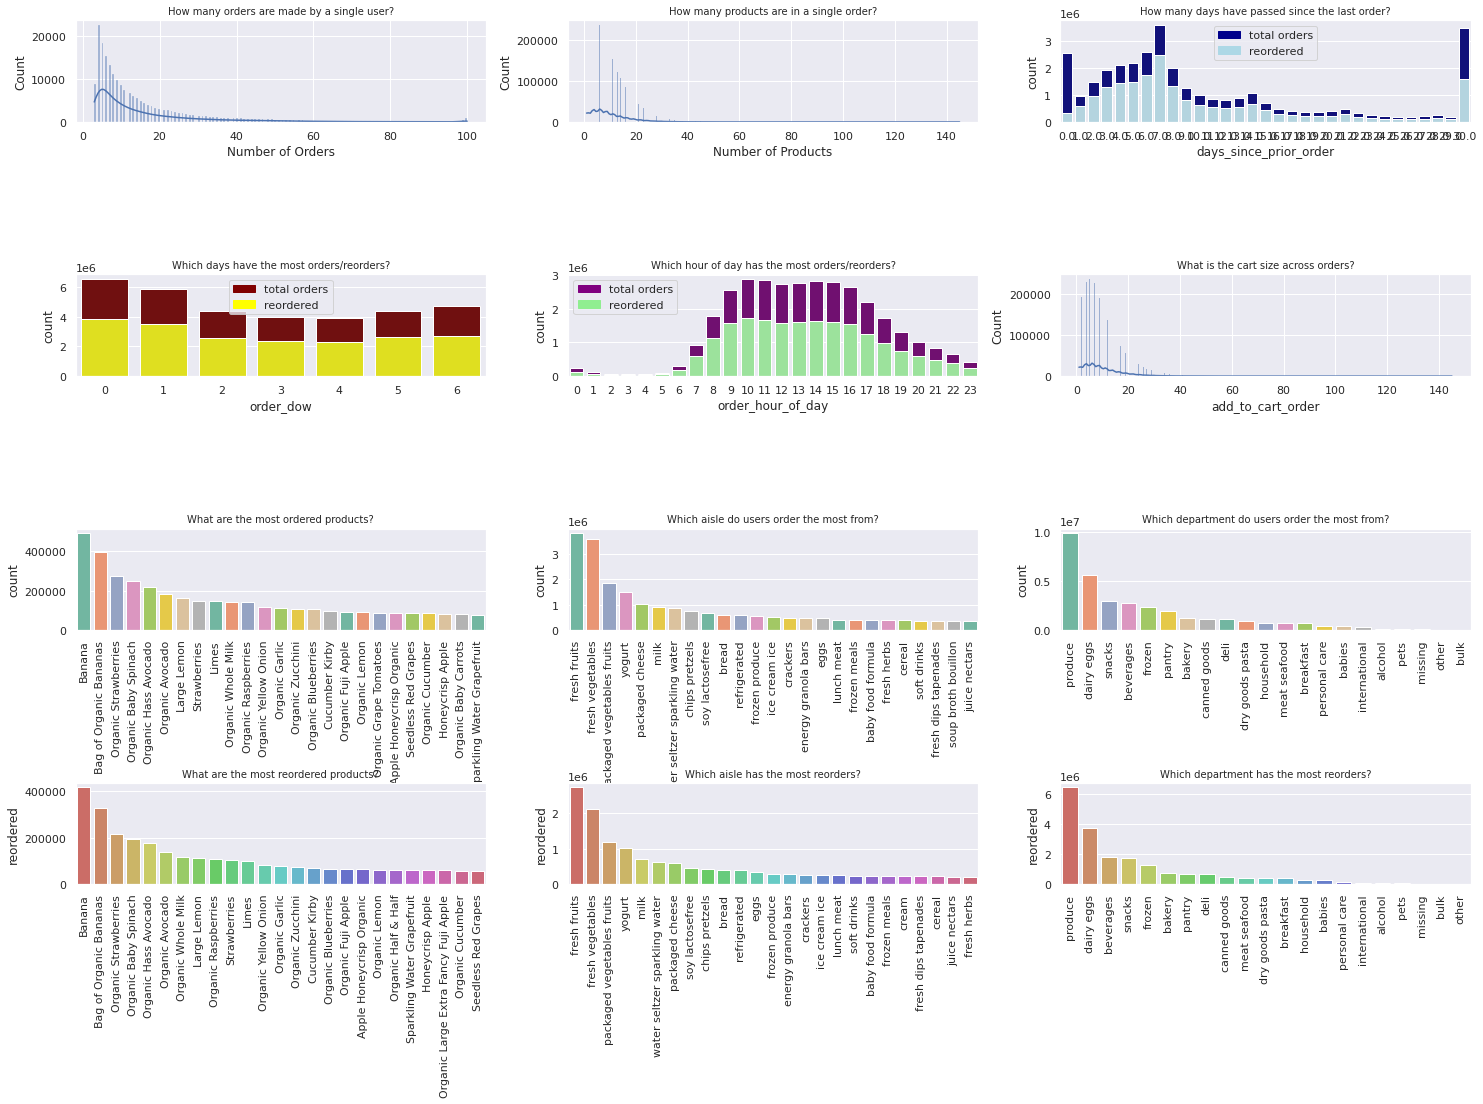

In [12]:

sns.set(style="darkgrid")
fig, ax = plt.subplots(4,3, figsize=(25,15))

# Plot 1
data = master_df[['user_id','order_id']].drop_duplicates().groupby('user_id').size().reset_index(name='Number of Orders').sort_values(by='Number of Orders', ascending=False)
ax[0,0] = CreateCharts(ax[0,0], data, x = "Number of Orders", y=None, chart_type = "hist", palette="bright")
ax[0,0].set_title('How many orders are made by a single user?', fontsize=10)


# Plot 2
data = master_df.groupby('order_id').size().reset_index(name='Number of Products').sort_values(by='Number of Products', ascending=False)
ax[0,1] = CreateCharts(ax[0,1], data, x = "Number of Products", y=None, chart_type = "hist", palette="dark")
ax[0,1].set_title('How many products are in a single order?', fontsize=10)


# Plot 3
import matplotlib.patches as mpatches
data1 = master_df.groupby('days_since_prior_order', as_index=False).size()
bar1 = sns.barplot(x="days_since_prior_order",  y="size", data=data1, color='darkblue', ax=ax[0,2])
data2 = master_df[master_df['reordered']==1].groupby('days_since_prior_order', as_index=False).size()
bar2 = sns.barplot(x="days_since_prior_order",  y="size", data=data2,  color='lightblue', ax=ax[0,2])
top_bar = mpatches.Patch(color='darkblue', label='total orders')
bottom_bar = mpatches.Patch(color='lightblue', label='reordered')
ax[0,2].legend(handles=[top_bar, bottom_bar])
ax[0,2].set_title('How many days have passed since the last order?', fontsize=10)
ax[0,2].set_ylabel('count')


# Plot 4

data1 = master_df.groupby('order_dow', as_index=False).size()
bar1 = sns.barplot(x="order_dow",  y="size", data=data1, color='maroon', ax=ax[1,0])
data2 = master_df[master_df['reordered']==1].groupby('order_dow', as_index=False).size()
bar2 = sns.barplot(x="order_dow",  y="size", data=data2,  color='yellow', ax=ax[1,0])
top_bar = mpatches.Patch(color='maroon', label='total orders')
bottom_bar = mpatches.Patch(color='yellow', label='reordered')
ax[1,0].legend(handles=[top_bar, bottom_bar])
ax[1,0].set_title('Which days have the most orders/reorders?', fontsize=10)
ax[1,0].set_ylabel('count')

# Plot 5
data1 = master_df.groupby('order_hour_of_day', as_index=False).size()
bar1 = sns.barplot(x="order_hour_of_day",  y="size", data=data1, color='purple', ax=ax[1,1])
data2 = master_df[master_df['reordered']==1].groupby('order_hour_of_day', as_index=False).size()
bar2 = sns.barplot(x="order_hour_of_day",  y="size", data=data2,  color='lightgreen', ax=ax[1,1])
top_bar = mpatches.Patch(color='purple', label='total orders')
bottom_bar = mpatches.Patch(color='lightgreen', label='reordered')
ax[1,1].legend(handles=[top_bar, bottom_bar])
ax[1,1].set_title('Which hour of day has the most orders/reorders?', fontsize=10)
ax[1,1].set_ylabel('count')

# Plot 6
data = master_df.groupby('order_id', as_index = False)['add_to_cart_order'].max()
ax[1,2] = CreateCharts(ax[1,2], data, x = "add_to_cart_order", y=None, chart_type = "hist", palette="bright")
ax[1,2].set_title('What is the cart size across orders?', fontsize=10)


# Plot 7
data = master_df.groupby('product_name', as_index = False)['product_id'].count().sort_values(by='product_id', ascending=False)
ax[2,0] = CreateCharts(ax[2,0], data.head(25), "product_name", "product_id", "bar", palette = "Set2")
ax[2,0].set_xticklabels(data.head(25)['product_name'], rotation = 90)
ax[2,0].set_title('What are the most ordered products?', fontsize=10)
ax[2,0].set_xlabel('')
ax[2,0].set_ylabel('count')

# Plot 8
data = master_df.groupby('aisle', as_index = False)['aisle_id'].count().sort_values(by='aisle_id', ascending=False)
ax[2,1] = CreateCharts(ax[2,1], data.head(25), "aisle", "aisle_id", "bar", palette = "Set2")
ax[2,1].set_xticklabels(data.head(25)['aisle'], rotation = 90)
ax[2,1].set_title('Which aisle do users order the most from?', fontsize=10)
ax[2,1].set_xlabel('')
ax[2,1].set_ylabel('count')

# Plot 9
data = master_df.groupby('department', as_index = False)['department_id'].count().sort_values(by='department_id', ascending=False)
ax[2,2] = CreateCharts(ax[2,2], data.head(25), "department", "department_id", "bar", palette = "Set2")
ax[2,2].set_xticklabels(data.head(25)['department'], rotation = 90)
ax[2,2].set_title('Which department do users order the most from?', fontsize=10)
ax[2,2].set_xlabel('')
ax[2,2].set_ylabel('count')


# Plot 10
data = master_df.groupby('product_name', as_index = False)['reordered'].sum().sort_values(by = 'reordered', ascending=False)
ax[3,0] = CreateCharts(ax[3,0], data.head(25),'product_name' , "reordered", "bar", palette = "hls")
ax[3,0].set_xticklabels(data.head(25)['product_name'], rotation = 90)
ax[3,0].set_title('What are the most reordered products?', fontsize=10)
ax[3,0].set_xlabel('')

# Plot 11
data = master_df.groupby('aisle', as_index = False)['reordered'].sum().sort_values(by = 'reordered', ascending=False)
ax[3,1] = CreateCharts(ax[3,1], data.head(25),'aisle' , "reordered", "bar", palette = "hls")
ax[3,1].set_xticklabels(data.head(25)['aisle'], rotation = 90)
ax[3,1].set_title('Which aisle has the most reorders?', fontsize=10)
ax[3,1].set_xlabel('')

# Plot 12
data = master_df.groupby('department', as_index = False)['reordered'].sum().sort_values(by = 'reordered', ascending=False)
ax[3,2] = CreateCharts(ax[3,2], data.head(25),'department' , "reordered", "bar", palette = "hls")
ax[3,2].set_xticklabels(data.head(25)['department'], rotation = 90)
ax[3,2].set_title('Which department has the most reorders?', fontsize=10)
ax[3,2].set_xlabel('')


plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=1.5)

plt.show()

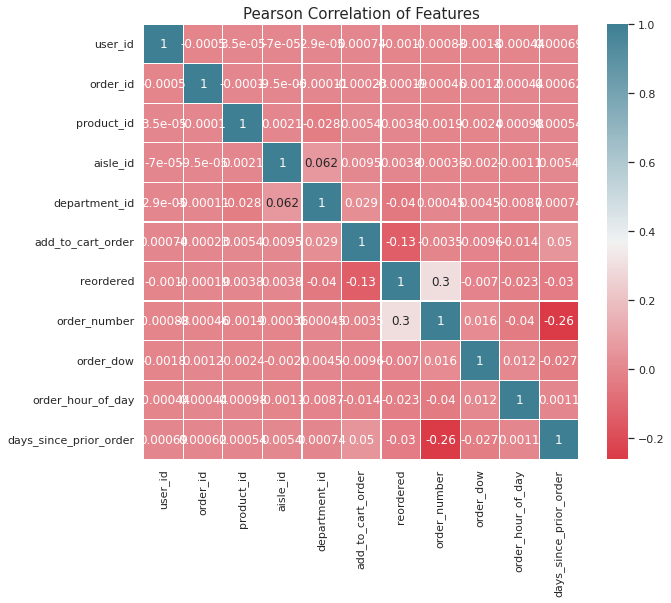

In [13]:
# Correlation
plt.figure(figsize=(10,8))
plt.title('Pearson Correlation of Features', size = 15)
colormap = sns.diverging_palette(10, 220, as_cmap = True)
sns.heatmap(master_df.corr(),
            cmap = colormap,
            square = True,
            annot = True,
            linewidths=0.1,vmax=1.0, linecolor='white',
            annot_kws={'fontsize':12 })
plt.show()

## 5. Feature Engineering

In [14]:
############################################ Helper Function 4 ############################################################
################################################# RUN PCA #################################################################

def run_PCA(data, features, name):
  pca = PCA(n_components=features)
  scale_data = pd.DataFrame(scale(data), columns = data.columns, index = data.index)
  pca_output = pca.fit_transform(data)
  df_pca = pd.DataFrame(data = pca_output, columns = [name+str(i) for i in range(features)], index = data.index)
  plot(pca.explained_variance_ratio_.cumsum(), linewidth=2)
  print("\nImportance of Components")
  print(pd.DataFrame(data = pca.components_, columns = data.columns, index = ['prod_'+str(i) for i in range(features)]))
  return df_pca


Importance of Components
aisle   air fresheners candles  asian foods  ...  white wines    yogurt
prod_0                0.000464     0.020537  ...    -0.000023  0.223725
prod_1                0.001283    -0.008505  ...     0.001193  0.550046
prod_2                0.001187     0.015831  ...     0.001847  0.659729
prod_3               -0.006602    -0.028403  ...    -0.010020  0.425199
prod_4                0.000087    -0.001246  ...     0.001429 -0.096026
prod_5               -0.002983    -0.018950  ...    -0.005988  0.056591
prod_6                0.001726     0.011285  ...    -0.000045 -0.075255
prod_7               -0.002450     0.005899  ...    -0.009346  0.031029
prod_8                0.000567    -0.009688  ...     0.000477 -0.034940
prod_9               -0.006836    -0.019371  ...    -0.006635 -0.075274

[10 rows x 134 columns]


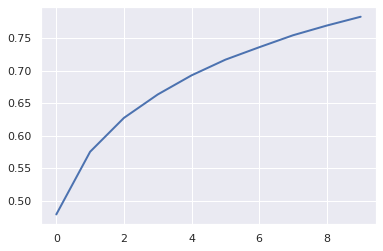

In [15]:
# PCA to find product preference
prod_pref = pd.pivot_table(master_df.groupby(['user_id','aisle'], as_index=False).size(), values='size', index='user_id',
                    columns=['aisle'], aggfunc=np.sum, fill_value=0)
prod_pref = run_PCA(prod_pref, 10, "prod_pref")

# PCA to find day preference
# day_pref = pd.pivot_table(master_df, values = 'order_dow', index = 'user_id',
#                columns = ['department'], aggfunc=np.median, fill_value=-1)

# day_pref = run_PCA(day_pref, 10, "day_pref")

In [16]:
dept_pref = pd.pivot_table(master_df.groupby(['user_id','department'], as_index=False).size(), values='size', index='user_id',
                    columns=['department'], aggfunc=np.sum, fill_value=0)
dept_pref['total'] = dept_pref.sum(axis = 1)

for dept in dept_pref.columns:
  dept_pref[dept+'_perc'] = dept_pref[dept] / dept_pref['total']

dept_pref

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,frozen,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks,total,alcohol_perc,babies_perc,bakery_perc,beverages_perc,breakfast_perc,bulk_perc,canned goods_perc,dairy eggs_perc,deli_perc,dry goods pasta_perc,frozen_perc,household_perc,international_perc,meat seafood_perc,missing_perc,other_perc,pantry_perc,personal care_perc,pets_perc,produce_perc,snacks_perc,total_perc
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,15,4,0,0,17,0,0,0,3,0,0,0,0,1,0,0,5,25,70,0.000000,0.000000,0.000000,0.214286,0.057143,0.0,0.000000,0.242857,0.000000,0.000000,0.000000,0.042857,0.000000,0.000000,0.000000,0.000000,0.014286,0.000000,0.0,0.071429,0.357143,1.0
2,0,0,2,9,3,0,4,49,24,0,28,0,3,1,0,0,11,2,0,43,47,226,0.000000,0.000000,0.008850,0.039823,0.013274,0.0,0.017699,0.216814,0.106195,0.000000,0.123894,0.000000,0.013274,0.004425,0.000000,0.000000,0.048673,0.008850,0.0,0.190265,0.207965,1.0
3,0,0,0,3,0,0,0,21,2,4,6,1,0,0,0,0,4,0,0,38,9,88,0.000000,0.000000,0.000000,0.034091,0.000000,0.0,0.000000,0.238636,0.022727,0.045455,0.068182,0.011364,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.0,0.431818,0.102273,1.0
4,2,0,2,3,0,0,1,0,2,0,3,2,0,0,0,0,0,0,0,2,1,18,0.111111,0.000000,0.111111,0.166667,0.000000,0.0,0.055556,0.000000,0.111111,0.000000,0.166667,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.111111,0.055556,1.0
5,0,0,0,0,0,0,1,9,1,1,2,1,4,0,0,0,3,0,0,23,1,46,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.021739,0.195652,0.021739,0.021739,0.043478,0.021739,0.086957,0.000000,0.000000,0.000000,0.065217,0.000000,0.0,0.500000,0.021739,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0,1,2,1,0,0,0,20,5,0,3,0,1,1,2,0,1,0,0,14,0,51,0.000000,0.019608,0.039216,0.019608,0.000000,0.0,0.000000,0.392157,0.098039,0.000000,0.058824,0.000000,0.019608,0.019608,0.039216,0.000000,0.019608,0.000000,0.0,0.274510,0.000000,1.0
206206,0,0,2,33,1,0,9,39,5,1,76,12,4,2,0,1,14,10,0,34,42,285,0.000000,0.000000,0.007018,0.115789,0.003509,0.0,0.031579,0.136842,0.017544,0.003509,0.266667,0.042105,0.014035,0.007018,0.000000,0.003509,0.049123,0.035088,0.0,0.119298,0.147368,1.0
206207,0,1,3,20,4,0,11,52,8,8,21,0,1,6,0,0,15,0,0,50,23,223,0.000000,0.004484,0.013453,0.089686,0.017937,0.0,0.049327,0.233184,0.035874,0.035874,0.094170,0.000000,0.004484,0.026906,0.000000,0.000000,0.067265,0.000000,0.0,0.224215,0.103139,1.0


In [22]:
# Create features to demonstrate trend of products prefered by users
model_input = prod_pref.merge(dept_pref, how='left', on='user_id')
# Create features to demonstrate trends of orders made by users
model_input = model_input.merge(master_df.groupby('user_id', as_index = False).agg(
              {'order_id':'count',
               'product_id':'count',
               'days_since_prior_order':'mean',
               'add_to_cart_order':'median',
               }).rename(
              columns={'order_id':'total_orders',
                       'product_id':'total_products',
                       'days_since_prior_order':'mean_days_since_prior_order',
                       'add_to_cart_order':'median_cart_size'}),
               how='left', on='user_id') 
model_input = model_input.set_index('user_id') 
model_input

,prod_pref0,prod_pref1,prod_pref2,prod_pref3,prod_pref4,prod_pref5,prod_pref6,prod_pref7,prod_pref8,prod_pref9,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,frozen,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks,total,alcohol_perc,babies_perc,bakery_perc,beverages_perc,breakfast_perc,bulk_perc,canned goods_perc,dairy eggs_perc,deli_perc,dry goods pasta_perc,frozen_perc,household_perc,international_perc,meat seafood_perc,missing_perc,other_perc,pantry_perc,personal care_perc,pets_perc,produce_perc,snacks_perc,total_perc,total_orders,total_products,mean_days_since_prior_order,median_cart_size
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-24.811636,3.449193,-1.611615,-0.470767,0.499494,-1.889779,2.688249,-3.661626,-2.663545,-1.404274,0,0,0,15,4,0,0,17,0,0,0,3,0,0,0,0,1,0,0,5,25,70,0.000000,0.000000,0.000000,0.214286,0.057143,0.0,0.000000,0.242857,0.000000,0.000000,0.000000,0.042857,0.000000,0.000000,0.000000,0.000000,0.014286,0.000000,0.0,0.071429,0.357143,1.0,70,70,17.828571,4.0
2,10.331587,39.529396,4.610970,14.683966,-7.375493,-2.020674,7.623749,4.111387,-9.993562,-12.404945,0,0,2,9,3,0,4,49,24,0,28,0,3,1,0,0,11,2,0,43,47,226,0.000000,0.000000,0.008850,0.039823,0.013274,0.0,0.017699,0.216814,0.106195,0.000000,0.123894,0.000000,0.013274,0.004425,0.000000,0.000000,0.048673,0.008850,0.0,0.190265,0.207965,1.0,226,226,16.973451,8.0
3,-9.247469,2.382711,-11.077053,0.846677,-0.395406,-2.786592,-6.674408,6.068586,-2.151597,-1.615339,0,0,0,3,0,0,0,21,2,4,6,1,0,0,0,0,4,0,0,38,9,88,0.000000,0.000000,0.000000,0.034091,0.000000,0.0,0.000000,0.238636,0.022727,0.045455,0.068182,0.011364,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.0,0.431818,0.102273,1.0,88,88,10.181818,4.0
4,-29.242883,-0.880035,-1.984256,2.315427,-0.296210,0.979940,0.805239,0.718109,0.038133,-0.867484,2,0,2,3,0,0,1,0,2,0,3,2,0,0,0,0,0,0,0,2,1,18,0.111111,0.000000,0.111111,0.166667,0.000000,0.0,0.055556,0.000000,0.111111,0.000000,0.166667,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.111111,0.055556,1.0,18,18,11.944444,2.0
5,-19.186003,-3.037864,0.186761,3.651016,0.856537,-2.306506,-5.230045,2.246390,0.926537,3.349839,0,0,0,0,0,0,1,9,1,1,2,1,4,0,0,0,3,0,0,23,1,46,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.021739,0.195652,0.021739,0.021739,0.043478,0.021739,0.086957,0.000000,0.000000,0.000000,0.065217,0.000000,0.0,0.500000,0.021739,1.0,46,46,9.369565,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,-20.426644,5.176025,0.814328,7.350438,-0.054096,-0.430744,-0.649518,-1.836450,0.543321,1.499715,0,1,2,1,0,0,0,20,5,0,3,0,1,1,2,0,1,0,0,14,0,51,0.000000,0.019608,0.039216,0.019608,0.000000,0.0,0.000000,0.392157,0.098039,0.000000,0.058824,0.000000,0.019608,0.019608,0.039216,0.000000,0.019608,0.000000,0.0,0.274510,0.000000,1.0,51,51,9.803922,7.0
206206,-6.163290,-0.200361,5.265753,-20.829086,0.906609,-13.375434,13.175896,4.436338,7.125448,-12.557535,0,0,2,33,1,0,9,39,5,1,76,12,4,2,0,1,14,10,0,34,42,285,0.000000,0.000000,0.007018,0.115789,0.003509,0.0,0.031579,0.136842,0.017544,0.003509,0.266667,0.042105,0.014035,0.007018,0.000000,0.003509,0.049123,0.035088,0.0,0.119298,0.147368,1.0,285,285,3.985965,3.0
206207,7.312526,7.660423,7.951974,-5.736292,1.752441,-3.142439,-5.273824,-5.671153,2.111562,10.067899,0,1,3,20,4,0,11,52,8,8,21,0,1,6,0,0,15,0,0,50,23,223,0.000000,0.004484,0.013453,0.089686,0.017937,0.0,0.049327,0.233184,0.035874,0.035874,0.094170,0.000000,0.004484,0.026906,0.000000,0.000000,0.067265,0.000000,0.0,0.224215,0.103139,1.0,223,223,13.278027,8.0


In [23]:
## Make data suitable for chosen model
import warnings
warnings.filterwarnings('ignore')

# check for outliers 
for col in model_input.columns:
  cap_val =  (np.mean(model_input[col]) + 3*np.std(model_input[col]))
  model_input[col+"_capped"] = 0
  model_input[col+"_capped"][model_input[col] >= 0 ] = np.minimum(cap_val,model_input[col][model_input[col] >= 0 ])
  model_input[col+"_capped"][model_input[col] < 0 ] = np.maximum((-1)*cap_val,model_input[col][model_input[col] < 0 ])
  print("\nOutliers", col)
  print ("cap: ", cap_val)
  print ("capped positive:", sum (model_input[col][model_input[col] >= 0 ] > cap_val))
  print ("capped negative:", sum (model_input[col][model_input[col] < 0 ] < (-1)*cap_val))


# normalize data
scaler = StandardScaler()
model_input_scaled = pd.DataFrame(scaler.fit_transform(model_input),columns = model_input.columns, index = model_input.index)


Outliers prod_pref0
cap:  134.50292580405164
capped positive: 4985
capped negative: 0

Outliers prod_pref1
cap:  60.36426288570743
capped positive: 2371
capped negative: 1574

Outliers prod_pref2
cap:  44.37619831377286
capped positive: 1965
capped negative: 1905

Outliers prod_pref3
cap:  36.910633495680486
capped positive: 1085
capped negative: 2799

Outliers prod_pref4
cap:  33.345024908779635
capped positive: 2375
capped negative: 811

Outliers prod_pref5
cap:  30.18457023037726
capped positive: 2287
capped negative: 1792

Outliers prod_pref6
cap:  26.898134137278312
capped positive: 1819
capped negative: 2375

Outliers prod_pref7
cap:  26.386070118870464
capped positive: 2092
capped negative: 2240

Outliers prod_pref8
cap:  23.777308486583046
capped positive: 2396
capped negative: 1430

Outliers prod_pref9
cap:  22.62086916282215
capped positive: 2197
capped negative: 1765

Outliers alcohol
cap:  19.111529508406097
capped positive: 2036
capped negative: 0

Outliers babies
cap:  3

In [25]:
model_input_scaled.columns

Index(['prod_pref0', 'prod_pref1', 'prod_pref2', 'prod_pref3', 'prod_pref4',
       'prod_pref5', 'prod_pref6', 'prod_pref7', 'prod_pref8', 'prod_pref9',
       ...
       'pantry_perc_capped', 'personal care_perc_capped', 'pets_perc_capped',
       'produce_perc_capped', 'snacks_perc_capped', 'total_perc_capped',
       'total_orders_capped', 'total_products_capped',
       'mean_days_since_prior_order_capped', 'median_cart_size_capped'],
      dtype='object', length=116)

In [26]:
# final dataset

X = model_input_scaled[['prod_pref0_capped',
       'prod_pref1_capped', 'prod_pref2_capped', 'prod_pref3_capped',
       'prod_pref4_capped', 'prod_pref5_capped', 'prod_pref6_capped', 
       'prod_pref7_capped', 'prod_pref8_capped', 'prod_pref9_capped',
       'alcohol_perc', 'babies_perc', 'bakery_perc', 'beverages_perc',
       'breakfast_perc', 'bulk_perc', 'canned goods_perc', 'dairy eggs_perc',
       'deli_perc', 'dry goods pasta_perc', 'frozen_perc', 'household_perc',
       'international_perc', 'meat seafood_perc', 'missing_perc', 'other_perc',
       'pantry_perc', 'personal care_perc', 'pets_perc', 'produce_perc',
       'snacks_perc', 'total_orders_capped',
       'total_products_capped', 'mean_days_since_prior_order_capped',
       'median_cart_size_capped']]

# sns.pairplot(X)

In [27]:
X

,prod_pref0_capped,prod_pref1_capped,prod_pref2_capped,prod_pref3_capped,prod_pref4_capped,prod_pref5_capped,prod_pref6_capped,prod_pref7_capped,prod_pref8_capped,prod_pref9_capped,alcohol_perc,babies_perc,bakery_perc,beverages_perc,breakfast_perc,bulk_perc,canned goods_perc,dairy eggs_perc,deli_perc,dry goods pasta_perc,frozen_perc,household_perc,international_perc,meat seafood_perc,missing_perc,other_perc,pantry_perc,personal care_perc,pets_perc,produce_perc,snacks_perc,total_orders_capped,total_products_capped,mean_days_since_prior_order_capped,median_cart_size_capped
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.625580,0.242380,-0.142061,-0.069639,0.120174,-0.224540,0.375810,-0.520630,-0.442467,-0.226726,-0.159697,-0.246317,-0.791620,0.976655,0.936542,-0.132587,-0.771458,0.823082,-0.720519,-0.736679,-0.883763,0.212770,-0.450956,-0.629792,-0.234443,-0.161152,-0.788260,-0.421737,-0.149198,-1.145788,2.673947,-0.498974,-0.498974,0.769981,-0.587255
2,0.320749,2.608302,0.421002,1.539978,-1.007908,-0.241407,1.073798,0.597128,-1.708556,-2.120295,-0.159697,-0.246317,-0.589225,-0.472684,-0.218869,-0.132587,-0.347296,0.576154,1.753261,-0.736679,0.654441,-0.461551,0.295108,-0.504220,-0.234443,-0.161152,-0.203592,-0.202761,-0.149198,-0.491615,1.185561,0.390301,0.390301,0.620318,0.777345
3,-0.206472,0.172446,-0.998559,0.070289,-0.008020,-0.340106,-0.948275,0.878573,-0.354040,-0.263057,-0.159697,-0.246317,-0.791620,-0.520303,-0.568488,-0.132587,-0.771458,0.783063,-0.191092,0.595252,-0.037251,-0.282754,-0.450956,-0.629792,-0.234443,-0.161152,-0.258306,-0.421737,-0.149198,0.838085,0.131048,-0.396366,-0.396366,-0.568356,-0.587255
4,-0.744904,-0.041505,-0.175780,0.226288,0.006190,0.145263,0.109511,0.109175,0.024185,-0.134327,1.920441,-0.246317,1.749556,0.581062,-0.568488,-0.132587,0.559940,-1.479588,1.867788,-0.736679,1.185488,1.286688,-0.450956,-0.629792,-0.234443,-0.161152,-1.031155,-0.421737,-0.149198,-0.927344,-0.335060,-0.795400,-0.795400,-0.259861,-1.269555
5,-0.474094,-0.183003,0.020669,0.368144,0.171320,-0.278241,-0.744010,0.328942,0.177636,0.591610,-0.159697,-0.246317,-0.791620,-0.803511,-0.568488,-0.132587,-0.250476,0.375504,-0.214111,-0.099668,-0.343958,-0.119504,4.436300,-0.629792,-0.234443,-0.161152,0.077715,-0.421737,-0.149198,1.213412,-0.672455,-0.635786,-0.635786,-0.710517,-0.246105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,-0.507502,0.355615,0.077456,0.761068,0.040872,-0.036523,-0.096223,-0.258170,0.111444,0.273144,-0.159697,0.292760,0.105266,-0.640620,-0.568488,-0.132587,-0.771458,2.238680,1.563282,-0.736679,-0.153439,-0.461551,0.651073,-0.073338,3.370782,-0.161152,-0.697769,-0.421737,-0.149198,-0.027866,-0.889351,-0.607284,-0.607284,-0.634496,0.436195
206206,-0.123422,0.003064,0.480252,-2.231941,0.178492,-1.704623,1.858993,0.643856,1.248353,-2.146561,-0.159697,-0.246317,-0.631125,0.158403,-0.476074,-0.132587,-0.014664,-0.182108,-0.311839,-0.633863,2.427038,0.200940,0.337865,-0.430640,-0.234443,0.252463,-0.195936,0.446484,-0.149198,-0.882275,0.580978,0.726630,0.726630,-1.652757,-0.928405
206207,0.239452,0.518527,0.723319,-0.628902,0.299657,-0.385962,-0.750202,-0.809600,0.382321,1.748004,-0.159697,-0.123030,-0.483944,-0.058449,-0.096057,-0.132587,0.410680,0.731364,0.115168,0.314531,0.285410,-0.461551,-0.198922,0.133773,-0.234443,-0.161152,0.112522,-0.421737,-0.149198,-0.304728,0.139691,0.373200,0.373200,-0.026456,0.777345


## 6. Modeling - k-means Clustering

In [ ]:
# # find the right number of clusters - Elbow Method

cluster_range = range(2,16)

kmeans_kwargs = {
      "init": "k-means++",
      "n_init": 10,
      "max_iter": 300,
      "random_state": None,
    }
   
# A list holds the SSE values for each k
sse = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)


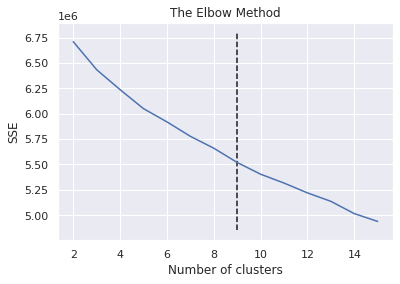

In [29]:
kn = KneeLocator(
    cluster_range, sse, curve="convex", direction="decreasing")
plt.plot(cluster_range,sse)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

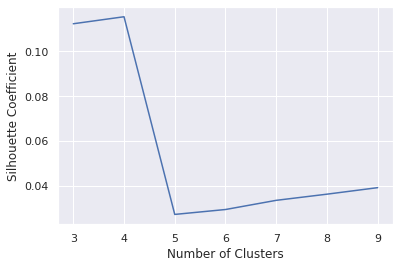

In [30]:
# find the right number of clusters - Silhouette Score Method

silhouette_coefficients = []
cluster_range = range(3,10)

for k in cluster_range:
     kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
     kmeans.fit(X)
     score = silhouette_score(X, kmeans.labels_)
     silhouette_coefficients.append(score)

plt.plot(cluster_range, silhouette_coefficients)
plt.xticks(cluster_range)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [31]:
# run model
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, **kmeans_kwargs)
kmeans.fit(X)
print("\nClusters",n_clusters)
print("\nsse",kmeans.inertia_)
print("\nIterations it took to converge: ", kmeans.n_iter_)
# print("\ncentroid locations: ",kmeans.cluster_centers_)
model_input['segment_'+str(n_clusters)] = kmeans.labels_

n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters, **kmeans_kwargs)
kmeans.fit(X)
print("\nClusters",n_clusters)
print("\nsse",kmeans.inertia_)
print("\nIterations it took to converge: ", kmeans.n_iter_)
# print("\ncentroid locations: ",kmeans.cluster_centers_)
model_input['segment_'+str(n_clusters)]= kmeans.labels_

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, **kmeans_kwargs)
kmeans.fit(X)
print("\nClusters",n_clusters)
print("\nsse",kmeans.inertia_)
print("\nIterations it took to converge: ", kmeans.n_iter_)
# print("\ncentroid locations: ",kmeans.cluster_centers_)
model_input['segment_'+str(n_clusters)]= kmeans.labels_

model_output = model_input


Clusters 8

sse 5634570.009966798

Iterations it took to converge:  68

Clusters 9

sse 5519408.372305705

Iterations it took to converge:  75

Clusters 10

sse 5418309.995853965

Iterations it took to converge:  69


## 7. Profiling

In [34]:
# clean our irrelavant datasets

# df_list = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
# print(df_list)
# del model_input
# del data
# del data1
# del data2
# # del day_pref
# del model_input_scaled
# del prod_pref
# del X
# del _10
# del _16
# del _17
# del _21
# del _22
# del _27
# del __
df_list = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
print(df_list)


['_10', 'dept_pref', 'master_df', 'model_output']


In [36]:
# create master dataset with output
master_df = master_df.merge(model_output[['total_orders_capped',
       'total_products_capped', 'mean_days_since_prior_order_capped',
       'median_cart_size_capped',
        'alcohol_perc', 'babies_perc', 'bakery_perc', 'beverages_perc',
       'breakfast_perc', 'bulk_perc', 'canned goods_perc', 'dairy eggs_perc',
       'deli_perc', 'dry goods pasta_perc', 'frozen_perc', 'household_perc',
       'international_perc', 'meat seafood_perc', 'missing_perc', 'other_perc',
       'pantry_perc', 'personal care_perc', 'pets_perc', 'produce_perc',
       'snacks_perc',
        'segment_8', 'segment_9', 'segment_10']],
        how='left', on='user_id')

In [37]:
master_df

,user_id,order_id,product_id,aisle_id,department_id,add_to_cart_order,reordered,product_name,aisle,department,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,total_orders_capped,total_products_capped,mean_days_since_prior_order_capped,median_cart_size_capped,alcohol_perc,babies_perc,bakery_perc,beverages_perc,breakfast_perc,bulk_perc,canned goods_perc,dairy eggs_perc,deli_perc,dry goods pasta_perc,frozen_perc,household_perc,international_perc,meat seafood_perc,missing_perc,other_perc,pantry_perc,personal care_perc,pets_perc,produce_perc,snacks_perc,segment_8,segment_9,segment_10
0,112108,1,49302,120,16,1,1,Bulgarian Yogurt,yogurt,dairy eggs,train,4,4,10,9.0,29.0,29.0,7.000,4.0,0.0,0.000,0.000,0.137931,0.00,0.0,0.206897,0.310345,0.000,0.000,0.000,0.00,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.241379,0.103448,4,6,5
1,112108,1,49683,83,4,4,0,Cucumber Kirby,fresh vegetables,produce,train,4,4,10,9.0,29.0,29.0,7.000,4.0,0.0,0.000,0.000,0.137931,0.00,0.0,0.206897,0.310345,0.000,0.000,0.000,0.00,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.241379,0.103448,4,6,5
2,112108,1,13176,24,4,6,0,Bag of Organic Bananas,fresh fruits,produce,train,4,4,10,9.0,29.0,29.0,7.000,4.0,0.0,0.000,0.000,0.137931,0.00,0.0,0.206897,0.310345,0.000,0.000,0.000,0.00,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.241379,0.103448,4,6,5
3,112108,1,43633,95,15,5,1,Lightly Smoked Sardines in Olive Oil,canned meat seafood,canned goods,train,4,4,10,9.0,29.0,29.0,7.000,4.0,0.0,0.000,0.000,0.137931,0.00,0.0,0.206897,0.310345,0.000,0.000,0.000,0.00,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.241379,0.103448,4,6,5
4,112108,1,10246,83,4,3,0,Organic Celery Hearts,fresh vegetables,produce,train,4,4,10,9.0,29.0,29.0,7.000,4.0,0.0,0.000,0.000,0.137931,0.00,0.0,0.206897,0.310345,0.000,0.000,0.000,0.00,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.241379,0.103448,4,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33819101,25247,3421083,11352,78,19,7,0,Organic Mini Sandwich Crackers Peanut Butter,crackers,snacks,prior,24,2,6,21.0,250.0,250.0,7.212,5.0,0.0,0.032,0.048,0.092000,0.02,0.0,0.048000,0.160000,0.024,0.028,0.028,0.02,0.004,0.0,0.0,0.0,0.076,0.0,0.0,0.312000,0.108000,4,7,0
33819102,25247,3421083,5020,3,19,10,1,Organic Sweet & Salty Peanut Pretzel Granola ...,energy granola bars,snacks,prior,24,2,6,21.0,250.0,250.0,7.212,5.0,0.0,0.032,0.048,0.092000,0.02,0.0,0.048000,0.160000,0.024,0.028,0.028,0.02,0.004,0.0,0.0,0.0,0.076,0.0,0.0,0.312000,0.108000,4,7,0
33819103,25247,3421083,21162,92,18,3,0,Organic Mixed Berry Yogurt & Fruit Snack,baby food formula,babies,prior,24,2,6,21.0,250.0,250.0,7.212,5.0,0.0,0.032,0.048,0.092000,0.02,0.0,0.048000,0.160000,0.024,0.028,0.028,0.02,0.004,0.0,0.0,0.0,0.076,0.0,0.0,0.312000,0.108000,4,7,0
33819104,25247,3421083,39678,74,17,6,1,Free & Clear Natural Dishwasher Detergent,dish detergents,household,prior,24,2,6,21.0,250.0,250.0,7.212,5.0,0.0,0.032,0.048,0.092000,0.02,0.0,0.048000,0.160000,0.024,0.028,0.028,0.02,0.004,0.0,0.0,0.0,0.076,0.0,0.0,0.312000,0.108000,4,7,0


In [38]:
# Distribution with other segments (K+1, K-1)
display(pd.crosstab(master_df['segment_9'], master_df['segment_10'], margins = False).apply(lambda r: round(r/r.sum(), 2), axis=1))
pd.crosstab(master_df['segment_9'], master_df['segment_8'], margins = False).apply(lambda r: round(r/r.sum(), 2), axis=1)

segment_10,0,1,2,3,4,5,6,7,8,9
segment_9,,,,,,,,,,
0,0.00,0.03,0.00,0.92,0.00,0.00,0.00,0.05,0.0,0.00
1,0.00,0.00,0.01,0.00,0.00,0.00,0.99,0.00,0.0,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0,0.00
3,0.00,0.01,0.02,0.00,0.97,0.00,0.00,0.00,0.0,0.00
4,0.00,0.01,0.96,0.00,0.00,0.00,0.00,0.02,0.0,0.00
5,0.02,0.58,0.00,0.01,0.00,0.07,0.00,0.32,0.0,0.00
6,0.00,0.02,0.00,0.00,0.00,0.89,0.00,0.09,0.0,0.00
7,0.89,0.07,0.00,0.00,0.00,0.02,0.00,0.02,0.0,0.00
8,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.05,0.0,0.93


segment_8,0,1,2,3,4,5,6,7
segment_9,,,,,,,,
0,0.01,0.00,0.01,0.01,0.00,0.00,0.98,0.0
1,0.00,0.00,0.01,0.00,0.00,0.99,0.00,0.0
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
3,0.96,0.00,0.04,0.00,0.00,0.00,0.00,0.0
4,0.01,0.00,0.96,0.02,0.00,0.00,0.00,0.0
5,0.00,0.00,0.02,0.69,0.19,0.00,0.09,0.0
6,0.03,0.00,0.00,0.84,0.12,0.00,0.00,0.0
7,0.03,0.00,0.00,0.01,0.94,0.00,0.01,0.0
8,0.00,0.98,0.00,0.01,0.00,0.00,0.01,0.0


In [39]:
def SegmentSummary(n):
  segment = 'segment_'+str(n)
  fig, ax = plt.subplots(1,n, figsize=(22,3))
  
  data = master_df.groupby([segment, 'aisle'], as_index = False).size().sort_values(by='size', ascending=False)
  for i in range(n):
    ax[i] = CreateCharts(ax[i], data[data[segment]==i].head(5), "aisle", "size", "bar", legend=False, size=None,hue=None, palette = "dark")
    ax[i].set_xticklabels(data[data[segment]==i].head(5)['aisle'], rotation = 90)
    ax[i].set_xlabel('')
    ax[i].set_title('Segment '+str(i), fontsize=10)
    ax[i].set_ylabel('')
  plt.show()
  
  fig, ax = plt.subplots(1,n, figsize=(22,3))
  data = master_df.groupby([segment, 'department'], as_index = False).size().sort_values(by='size', ascending=False)
  for i in range(n):
    ax[i] = CreateCharts(ax[i], data[data[segment]==i].head(5), "department", "size", "bar", legend=False, size=None,hue=None, palette = "Set2")
    ax[i].set_xticklabels(data[data[segment]==i].head(5)['department'], rotation = 90)
    ax[i].set_xlabel('')
    ax[i].set_title('Segment '+str(i), fontsize=10)
    ax[i].set_ylabel('')
  plt.show()  

  summary = master_df.groupby(segment, as_index = False).agg(
              { segment: 'count', 
                'reordered':'sum',
               'order_dow': 'median',
               'order_hour_of_day':'median',
               'days_since_prior_order': 'median',
               'total_orders_capped': ['sum', 'mean'],
               'total_products_capped': ['sum','mean'],
               'mean_days_since_prior_order_capped':'mean',
               'median_cart_size_capped':'median',
               }).astype(float)

  summary['n_size_perc'] = [round(i/sum(summary[segment]['count']),2) for i in summary[segment]['count']]
  summary['reordered_perc'] = [round(i/sum(summary['reordered']['sum']),2) for i in summary['reordered']['sum']]
  summary['total_orders_capped_perc'] = [round(i/sum(summary['total_orders_capped']['sum']),2) for i in summary['total_orders_capped']['sum']]
  summary['total_products_capped_perc'] = [round(i/sum(summary['total_products_capped']['sum']),2) for i in summary['total_products_capped']['sum']]
  display(summary)
  return summary

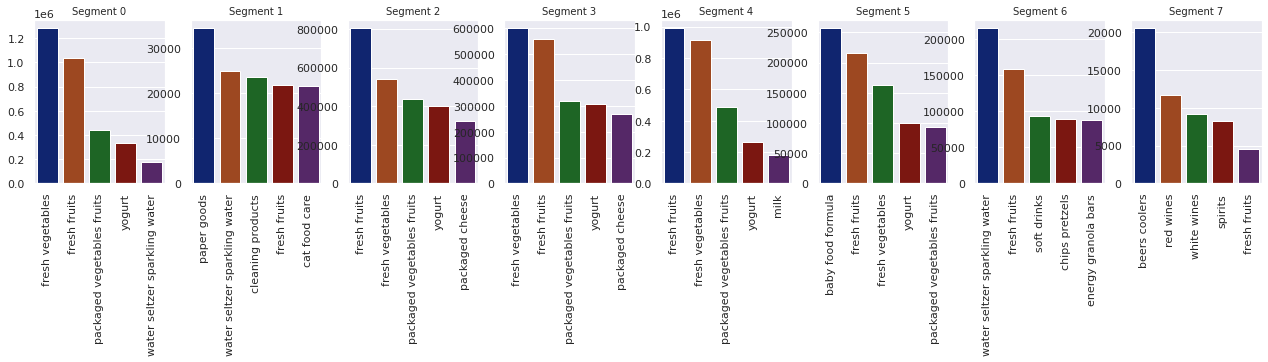

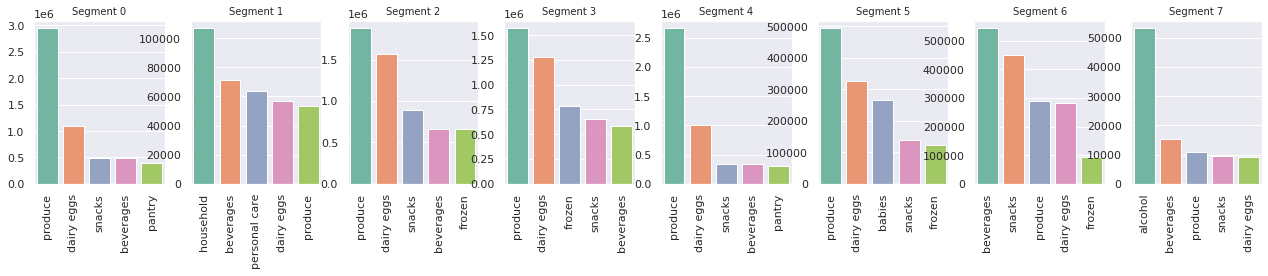

segment_8   reordered  ... total_orders_capped_perc total_products_capped_perc
        count         sum  ...                                                    
0 7,132,821.0 4,969,464.0  ...                     0.32                       0.32
1   572,600.0   244,341.0  ...                     0.01                       0.01
2 8,262,435.0 5,879,373.0  ...                      0.4                        0.4
3 7,701,873.0 3,343,290.0  ...                      0.1                        0.1
4 6,020,963.0 2,989,344.0  ...                     0.07                       0.07
5 1,906,473.0 1,246,850.0  ...                     0.08                       0.08
6 2,094,731.0 1,220,373.0  ...                     0.03                       0.03
7   127,210.0    62,325.0  ...                      0.0                        0.0

[8 rows x 15 columns]

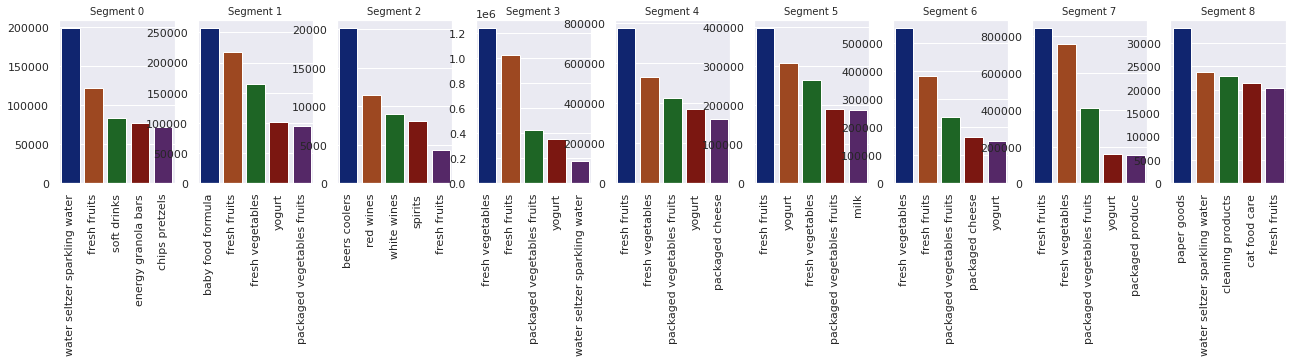

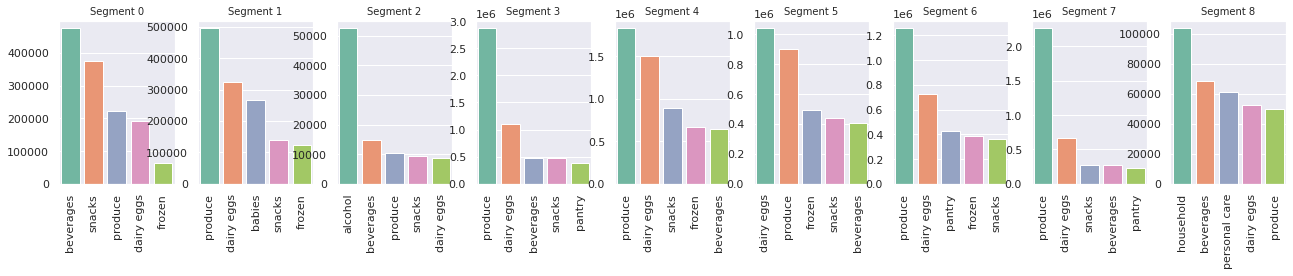

segment_9   reordered  ... total_orders_capped_perc total_products_capped_perc
        count         sum  ...                                                    
0 1,652,401.0   992,050.0  ...                     0.03                       0.03
1 1,911,557.0 1,252,313.0  ...                     0.08                       0.08
2   123,966.0    60,771.0  ...                      0.0                        0.0
3 6,986,175.0 4,915,007.0  ...                     0.32                       0.32
4 8,139,463.0 5,751,980.0  ...                     0.39                       0.39
5 4,700,134.0 2,272,437.0  ...                     0.06                       0.06
6 5,015,494.0 2,054,520.0  ...                     0.07                       0.07
7 4,742,480.0 2,423,346.0  ...                     0.06                       0.06
8   547,436.0   232,936.0  ...                     0.01                       0.01

[9 rows x 15 columns]

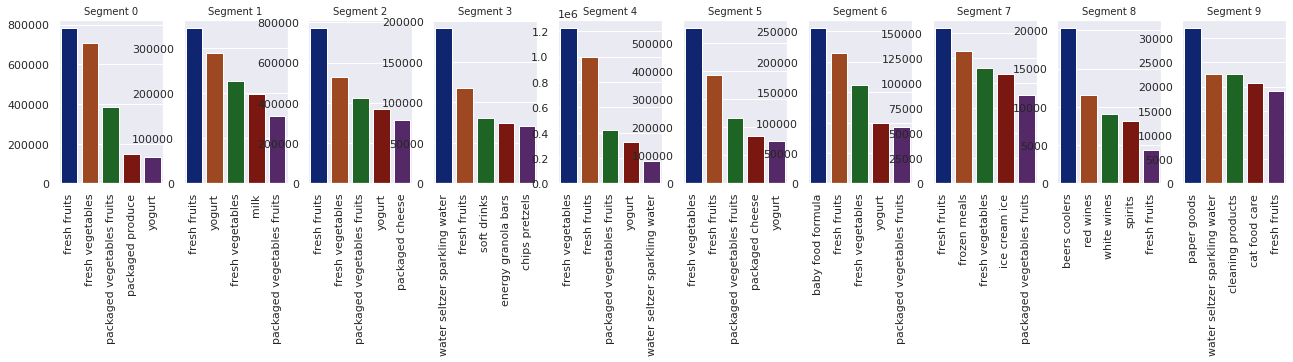

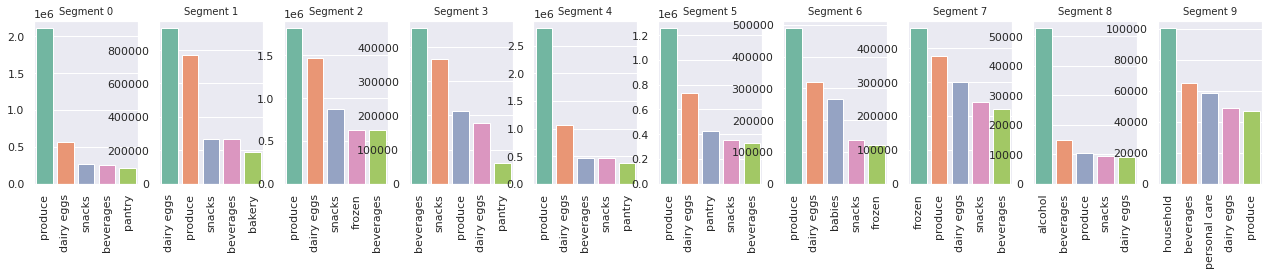

segment_10   reordered  ... total_orders_capped_perc total_products_capped_perc
        count         sum  ...                                                    
0 4,347,405.0 2,205,651.0  ...                     0.05                       0.05
1 3,386,418.0 1,760,202.0  ...                     0.05                       0.05
2 7,948,219.0 5,650,292.0  ...                     0.39                       0.39
3 1,572,419.0   944,967.0  ...                     0.02                       0.02
4 6,826,422.0 4,792,924.0  ...                     0.31                       0.31
5 4,922,720.0 2,003,286.0  ...                     0.06                       0.06
6 1,890,652.0 1,238,124.0  ...                     0.08                       0.08
7 2,283,213.0 1,078,921.0  ...                     0.03                       0.03
8   125,262.0    61,503.0  ...                      0.0                        0.0
9   516,376.0   219,490.0  ...                     0.01                       0.01

[10 rows x 15 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
pd.options.display.float_format = '{:,}'.format
summary_9 = SegmentSummary(8)
summary_8 = SegmentSummary(9)
summary_7 = SegmentSummary(10)

from google.colab import files
master_df.to_csv("master_df.csv")
files.download('master_df.csv')